# Coding Challenge 

## Aufgabe: Datenexploration und Vorhersagemodell

_Wir schicken dir im Nachgang einen Datensatz zu („flights.csv“), der Informationen über Flüge enthält. Bitte:_

1. _Führe eine explorative Datenanalyse durch, insbesondere bezüglich der Frage, welche Faktoren/Treiber Verspätungen bei Ankünften (arr_delay) und Abflügen (dep_delay) beeinflussen._
1. _Erstelle ein Vorhersagemodell für die binäre Aussage, ob ein Abflug mehr als 30 Minuten verspätet ist (ohne Nutzung der Verspätung der Ankunft). Nutze dazu einen geeigneten Evaluationsdatensatz._


## Preprocess the data

### Apply setting 

In [1]:
# load libraries
import numpy as np
import pandas as pd
import sys, time, os
from datetime import date
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# determine the path to the source folder 
pth_to_src = 'C:/DEV/flight_analysis_and_table_printing/src/'

# get date of today:
# Reason: Create outputfolder with current date to store plots and trained model if wanted.
today = date.today().strftime('%Y%m%d')

# input folder:
input_folder  = pth_to_src + 'input/'

# output folder:
output_folder = pth_to_src+ 'output/'+today+'/' # with date of today. This way a daily history of results can be automatically stored.
output_folder_plots  = output_folder+'plots/'
output_folder_model  = output_folder+'model/'

# create output_folder if not existant:
os.makedirs(output_folder,exist_ok=True)
os.makedirs(output_folder_plots,exist_ok=True)
os.makedirs(output_folder_model,exist_ok=True)
# load utility functions
sys.path.append(pth_to_src+'/utils/')
from utility import *
# reload functions from utility
from importlib import reload
reload(sys.modules['utility'])    

# set random seed for reproduceability
np.random.seed(888) 

### Load the data

In [2]:
# Read the dataframe:
df = pd.read_csv(pth_to_src+'input/flights.csv',  sep=",",parse_dates=['time_hour'] )
df

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,9E,3393,NaN,JFK,DCA,NaN,213,14,55,2013-09-30 14:00:00
336772,2013,9,30,NaN,2200,NaN,NaN,2312,NaN,9E,3525,NaN,LGA,SYR,NaN,198,22,0,2013-09-30 22:00:00
336773,2013,9,30,NaN,1210,NaN,NaN,1330,NaN,MQ,3461,N535MQ,LGA,BNA,NaN,764,12,10,2013-09-30 12:00:00
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,3572,N511MQ,LGA,CLE,NaN,419,11,59,2013-09-30 11:00:00


### Clean the dataset and add addtional features

In [4]:
# remove missing air_time:
# Reason: flights seem to be cancelled
print('Number of observations before cleaning missing air_time: %s'%len(df))
df = df.drop( df.index[df['air_time'].isna()] ,axis=0)  
print('Number of observations before cleaning missing air_time: %s'%len(df))
df = df.reset_index(drop=True)

Number of observations before cleaning missing air_time: 327346
Number of observations before cleaning missing air_time: 327346


In [4]:
# remove missing air_time:
# Reason: flights seem to be cancelled
print('Number of observations before cleaning missing air_time: %s'%len(df))
df = df.drop( df.index[df['air_time'].isna()] ,axis=0)  
print('Number of observations before cleaning missing air_time: %s'%len(df))
df = df.reset_index(drop=True)

Number of observations before cleaning missing air_time: 327346
Number of observations before cleaning missing air_time: 327346


In [5]:
# create a date column:
# Reason: Easy to read and useful to organize observations
df['date'] = pd.to_datetime(df[["year", "month", "day"]])
# combine the date and sched_dep_time to a sched_dep_date_time column:
df['sched_dep_date_time'] =  pd.to_datetime(df.date.astype(str)+' '+pd.to_datetime(df.sched_dep_time, format='%H%M').dt.time.astype(str)) 
# combine the date and sched_arr_time to a sched_arr_date_time column:
#df['sched_arr_time_date']  =  pd.to_datetime(df.date.astype(str)+' '+pd.to_datetime(df.sched_arr_time, format='%H%M').dt.time.astype(str)) 

In [6]:
# Add a flight id column:
# Reason: Ensures an unique identifier for flights at a given day.
df['flight_id'] = [str(x) + '_' + str(y) + '_'+str(z) for x, y, z in zip(df.tailnum, df.flight,df.hour)] 

In [7]:
# Add week day information:
# Reason: Allows to determine week day of a given flight.
df['weekday'] = df.sched_dep_date_time.dt.day_name()

In [8]:
# Add month name information:
# Reason: Allows to determine the month name of a given flight and is easier readable than a numeric month value
df['month_name'] = df.sched_dep_date_time.dt.month_name()

In [9]:
# Add week number information:
# Reason: Allows to determine the week number of a given flight and can be used to structure the day in a week sequentially.
df['week_num'] = df.sched_dep_date_time.dt.isocalendar().week

In [10]:
# Add number of flights information:
# Reason: Allows to determine the number of flights at a given day and origin. Thus, it indicates the overall depature airplane 'traffic'.
df['num_flights'] = df.groupby([df.date,df.origin])['flight_id'].transform('count')

In [11]:
# define the target variables for the later prediction task:
# Reason: Needed later as response variable.
df['depart_delay_is_large'] = (df['dep_delay']>30)*1

In [12]:
# Add the lagged average value of a variable 'dep_delay' with lag 'lag'
# Reason: Allows to determine the delay at previous days - overall and/or for the same carrier and/or origin.
# This way "blocks" or "traffic jams" can be identified and taken into account.

def add_lagged_var(df, lag = 1, groupby_var = None, var_name='dep_delay', lag_minutes = 0 ):
    """Add the lagged average value of a variable 'var_name' with lag 'lag' and do so while optionally grouping by another variable 'groupby_var' """
    # initialize the grouping variables:
    groupby_vars = ['date']
    # specify the name of the new variable
    new_var_name =  'avg_'+var_name+ '_last_'+str(lag)+'_day'
    # add 's' to the name of the new variable in case of lag larger than 1
    if lag>1:
        new_var_name += 's'    
    # in case of grouping by origin, modifiy the name of the new variable and the groupin variables    
    if groupby_var is not None:
        groupby_vars += groupby_var
        new_var_name += '_at_'+'_'.join(str(e) for e in groupby_var)  
    # exit if the variable already exists
    if new_var_name in df.columns:
        return df  
    
    # get the lagged values 
    gps_df = pd.DataFrame(df.groupby(groupby_vars)[var_name].agg('mean'))
    gps_df.columns=[new_var_name]
    # update multindex:
    if isinstance(gps_df.index, pd.MultiIndex):
        gps_df.index = gps_df.index.set_levels( gps_df.index.levels[0]+ timedelta(days=lag, minutes = lag_minutes)  , level=0)
    # update index:        
    else:
        gps_df.set_index(gps_df.index + timedelta(days=lag, minutes = lag_minutes), inplace=True )
        
    # add the lagged values
    df = pd.merge(df, gps_df, left_on = groupby_vars, right_on = groupby_vars, how='left')  
    # replace missing values is group averages:
    if groupby_var is not None:
        df[new_var_name] = df.groupby(groupby_var)[new_var_name].transform(lambda x: x.fillna(x.mean()))
    # replace missing values averages:
    else:
        df[new_var_name] = df[new_var_name].fillna(df[new_var_name].mean())    
    
    return df   

# Add average delay from last day, last 2 days:                  
df = add_lagged_var(df, 1 )
df = add_lagged_var(df, 2 )

# Add average delay from last day, last 2 days at the same origin: 
df = add_lagged_var(df, 1, groupby_var =['origin'])
df = add_lagged_var(df, 2, groupby_var =['origin'])

# Add average delay from last day, last 2 days for the same carrier: 
df = add_lagged_var(df, 1, groupby_var =['carrier'])
df = add_lagged_var(df, 2, groupby_var =['carrier'])

# Add average delay from last day, last 2 days at the same origin and for the same carrier: 
df = add_lagged_var(df, 1, groupby_var =['origin','carrier'])
df = add_lagged_var(df, 2, groupby_var =['origin','carrier'])

# Add average of large delays occurances from last day, last 2 days:   
df = add_lagged_var(df, 1, var_name ='depart_delay_is_large' )
df = add_lagged_var(df, 2, var_name ='depart_delay_is_large' )

In [13]:
# sort dataframe according to 'sched_dep_date_time' in ascending order 
# Reason: Allows for an easier overview.
df = df.sort_values(['sched_dep_date_time'])
# reset the index:
df = df.reset_index(drop=True)

In [14]:
# number of large delays at same day until scheduled departure:
# Reason: Allows to determine the delay at the present day - overall and/or for the same carrier and/or origin.
# This way "blocks" or "traffic jams" at the present day before the scheduled flight can be identified and taken into account.

def get_cumsum_vars(df, group_vars = ['date','sched_dep_date_time'], new_var_name = 'num_previous_delays', var_name='depart_delay_is_large', metric = 'cumsum'):
    # exit if the variable already exists
    if new_var_name in df.columns:
        return df      
    gps_df_sum    = df.groupby(group_vars)[var_name].agg('sum')
    # compute the cumulative sum 
    gps_df_cumsum = gps_df_sum.groupby(level=0).agg('cumsum') 
    if metric == 'cumcount': 
        gps_df_cumcount    = gps_df_sum.groupby(level=0).agg('cumcount')
        gps_df_cumcount[0] = 1
        gps_df_cumsum /= gps_df_cumcount
    # and subtract the depart_delay_is_large at the time of appearance (so that depart_delay_is_large is not known in before for a given observation)
    gps_df_cumsum -= gps_df_sum
    # check:
    if 0:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            df1 = pd.merge(gps_df_cumsum.loc[gps_df.index.get_level_values('date')=='2013-01-01',:], gps_df_sum.loc[gps_df.index.get_level_values('date')=='2013-01-01',:],left_index=True, right_index=True)
            df1.columns = ['1','2']
            print(df1)
    # convert to dataframe and rename the column:        
    gps_d_cumsum = gps_df_cumsum.to_frame(name = new_var_name)
    # add the variable to the dataframe:
    df = pd.merge(df, gps_d_cumsum, left_on = group_vars, right_index = True, how='left')     
    return df


# Add number of delay at the present day before the scheduled flight:  
df = get_cumsum_vars(df)
# Add number of delay at the present day before the scheduled flight at the same origin: 
df = get_cumsum_vars(df, group_vars = ['date','origin','sched_dep_date_time'], new_var_name = 'num_previous_delays_at_origin')
# Add number of delay at the present day before the scheduled flight for the same carrier: 
df = get_cumsum_vars(df, group_vars = ['date','carrier','sched_dep_date_time'], new_var_name = 'num_previous_delays_carrier')
# Add number of delay at the present day before the scheduled flight at the same origin and for the same carrier: 
df = get_cumsum_vars(df, group_vars = ['date','origin','carrier','sched_dep_date_time'], new_var_name = 'num_previous_delays_at_origin_and_carrier')


# Add average delay at the present day before the scheduled flight: 
df = get_cumsum_vars(df, new_var_name = 'avg_previous_delays', var_name='dep_delay', metric = 'cummean')
# Add average delay at the present day before the scheduled flight at the same origin: 
df = get_cumsum_vars(df, group_vars = ['date','origin','sched_dep_date_time'], new_var_name = 'avg_previous_delays_at_origin', var_name='dep_delay', metric = 'cummean')
# Add average delay at the present day before the scheduled flight for the same carrier:
df = get_cumsum_vars(df, group_vars = ['date','carrier','sched_dep_date_time'], new_var_name = 'avg_previous_delays_carrier', var_name='dep_delay', metric = 'cummean')
# Add average delay at the present day before the scheduled flight at the same origin and for the same carrier: 
df = get_cumsum_vars(df, group_vars = ['date','origin','carrier','sched_dep_date_time'], new_var_name = 'avg_previous_delays_at_origin_and_carrier', var_name='dep_delay', metric = 'cummean')

### Explorative analysis of the data

#### Overall

In [15]:
# check for missing values:
pd.DataFrame([df.isna().sum(),df.isna().mean()],index=['Number of missing values', 'Rate of missing values']).T

,Number of missing values,Rate of missing values
year,0.0,0.000000
month,0.0,0.000000
day,0.0,0.000000
dep_time,0.0,0.000000
sched_dep_time,0.0,0.000000
dep_delay,0.0,0.000000
arr_time,0.0,0.000000
sched_arr_time,0.0,0.000000
arr_delay,0.0,0.000000
carrier,0.0,0.000000


In [16]:
# get basic descriptive statistics of the data set:
df.describe()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,...,avg_depart_delay_is_large_last_1_day,avg_depart_delay_is_large_last_2_days,num_previous_delays,num_previous_delays_at_origin,num_previous_delays_carrier,num_previous_delays_at_origin_and_carrier,avg_previous_delays,avg_previous_delays_at_origin,avg_previous_delays_carrier,avg_previous_delays_at_origin_and_carrier
count,327346.0,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,...,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000
mean,2013.0,6.564803,15.740825,1348.789883,1340.335098,12.555156,1501.908238,1532.788426,6.895377,1943.104501,...,0.146040,0.145121,45.787671,63.210575,64.491694,69.950624,3491.781962,5379.744781,5401.350993,6059.326132
std,0.0,3.413444,8.777376,488.319979,467.413156,40.065688,532.888731,497.979124,44.633292,1621.523684,...,0.100062,0.099961,54.900634,61.602352,64.186201,64.153092,5840.577395,6608.580846,7055.389516,7027.935744
min,2013.0,1.000000,1.000000,1.000000,500.000000,-43.000000,1.000000,1.000000,-86.000000,1.000000,...,0.025694,0.025694,0.000000,0.000000,0.000000,0.000000,-1501.000000,-1340.000000,-1570.000000,-1291.000000
25%,2013.0,4.000000,8.000000,907.000000,905.000000,-5.000000,1104.000000,1122.000000,-17.000000,544.000000,...,0.073145,0.073034,9.000000,17.000000,19.000000,24.000000,113.000000,853.000000,883.000000,1367.000000
50%,2013.0,7.000000,16.000000,1400.000000,1355.000000,-2.000000,1535.000000,1554.000000,-5.000000,1467.000000,...,0.110701,0.110619,27.000000,46.000000,44.000000,52.000000,1394.000000,3156.000000,2906.000000,3807.000000
75%,2013.0,10.000000,23.000000,1744.000000,1729.000000,11.000000,1940.000000,1944.000000,14.000000,3412.000000,...,0.197154,0.189189,60.000000,89.000000,86.000000,94.000000,4325.000000,7083.000000,6784.000000,7951.750000
max,2013.0,12.000000,31.000000,2400.000000,2359.000000,1301.000000,2400.000000,2359.000000,1272.000000,8500.000000,...,0.619048,0.619048,494.000000,493.000000,494.000000,494.000000,66728.000000,66657.000000,66728.000000,66728.000000


#### Delay per carrier

In [17]:
df[['carrier','arr_delay', 'dep_delay']].groupby('carrier').describe()

arr_delay                                                          \
            count       mean        std   min    25%   50%    75%     max   
carrier                                                                     
9E        17294.0   7.379669  50.086778 -68.0 -21.00  -7.0  15.00   744.0   
AA        31947.0   0.364291  42.516182 -75.0 -21.00  -9.0   8.00  1007.0   
AS          709.0  -9.930889  36.482633 -74.0 -32.00 -17.0   2.00   198.0   
B6        54049.0   9.457973  42.842297 -71.0 -14.00  -3.0  17.00   497.0   
DL        47658.0   1.644341  44.402289 -71.0 -20.00  -8.0   8.00   931.0   
EV        51108.0  15.796431  49.861469 -62.0 -14.00  -1.0  26.00   577.0   
F9          681.0  21.920705  61.645997 -47.0  -9.00   6.0  31.00   834.0   
FL         3175.0  20.115906  54.087671 -44.0  -7.00   5.0  24.00   572.0   
HA          342.0  -6.915205  75.129420 -70.0 -27.75 -13.0   2.75  1272.0   
MQ        25037.0  10.774733  43.174306 -53.0 -13.00  -1.0  18.00  1127.0   
OO           29.0  11.931034  48.584926 -26.0 -16.00  -7.0   6.00   157.0   
UA        57782.0   3.558011  40.984344 -75.0 -18.00  -6.0  12.00   455.0   
US        19831.0   2.129595  33.066952 -70.0 -15.00  -6.0   8.00   492.0   
VX         5116.0   1.764464  49.966450 -86.0 -23.00  -9.0   8.00   676.0   
WN        12044.0   9.649120  46.877702 -58.0 -15.00  -3.0  15.00   453.0   
YV          544.0  15.556985  52.922234 -46.0 -16.00  -2.0  24.25   381.0   

        dep_delay                                                       
            count       mean        std   min  25%  50%    75%     max  
carrier                                                                 
9E        17294.0  16.439574  45.487513 -24.0 -6.0 -2.0  16.00   747.0  
AA        31947.0   8.569130  37.365267 -24.0 -6.0 -3.0   4.00  1014.0  
AS          709.0   5.830748  31.426798 -21.0 -7.0 -3.0   3.00   225.0  
B6        54049.0  12.967548  38.380215 -43.0 -5.0 -1.0  12.00   502.0  
DL        47658.0   9.223950  39.656296 -33.0 -5.0 -2.0   5.00   960.0  
EV        51108.0  19.838929  46.446174 -32.0 -5.0 -1.0  25.00   548.0  
F9          681.0  20.201175  58.404339 -27.0 -4.0  0.0  18.00   853.0  
FL         3175.0  18.605984  52.491059 -22.0 -4.0  1.0  17.00   602.0  
HA          342.0   4.900585  74.109901 -16.0 -7.0 -4.0  -1.00  1301.0  
MQ        25037.0  10.445381  39.025198 -26.0 -7.0 -3.0   9.00  1137.0  
OO           29.0  12.586207  43.065994 -14.0 -9.0 -6.0   4.00   154.0  
UA        57782.0  12.016908  35.547921 -20.0 -4.0  0.0  11.00   483.0  
US        19831.0   3.744693  27.939106 -19.0 -7.0 -4.0   0.00   500.0  
VX         5116.0  12.756646  44.016255 -20.0 -4.0  0.0   8.00   653.0  
WN        12044.0  17.661657  43.237454 -13.0 -2.0  1.0  17.00   471.0  
YV          544.0  18.898897  49.164838 -16.0 -7.0 -2.0  22.25   387.0

<AxesSubplot:title={'center':'Delay per carrier'}, xlabel='carrier'>

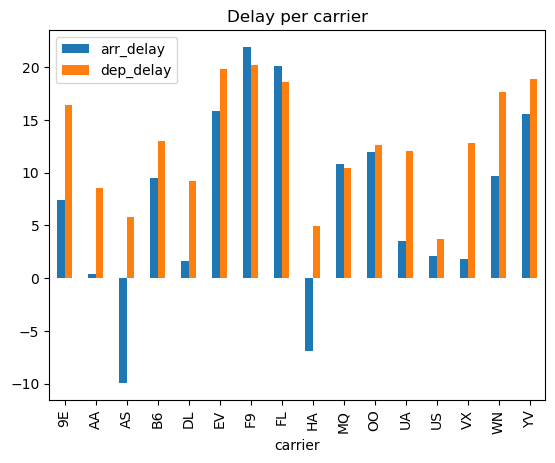

In [18]:
df[['carrier','arr_delay', 'dep_delay']].groupby('carrier').mean().plot(title= 'Delay per carrier',kind='bar')

#### Delay per carrier deep dive

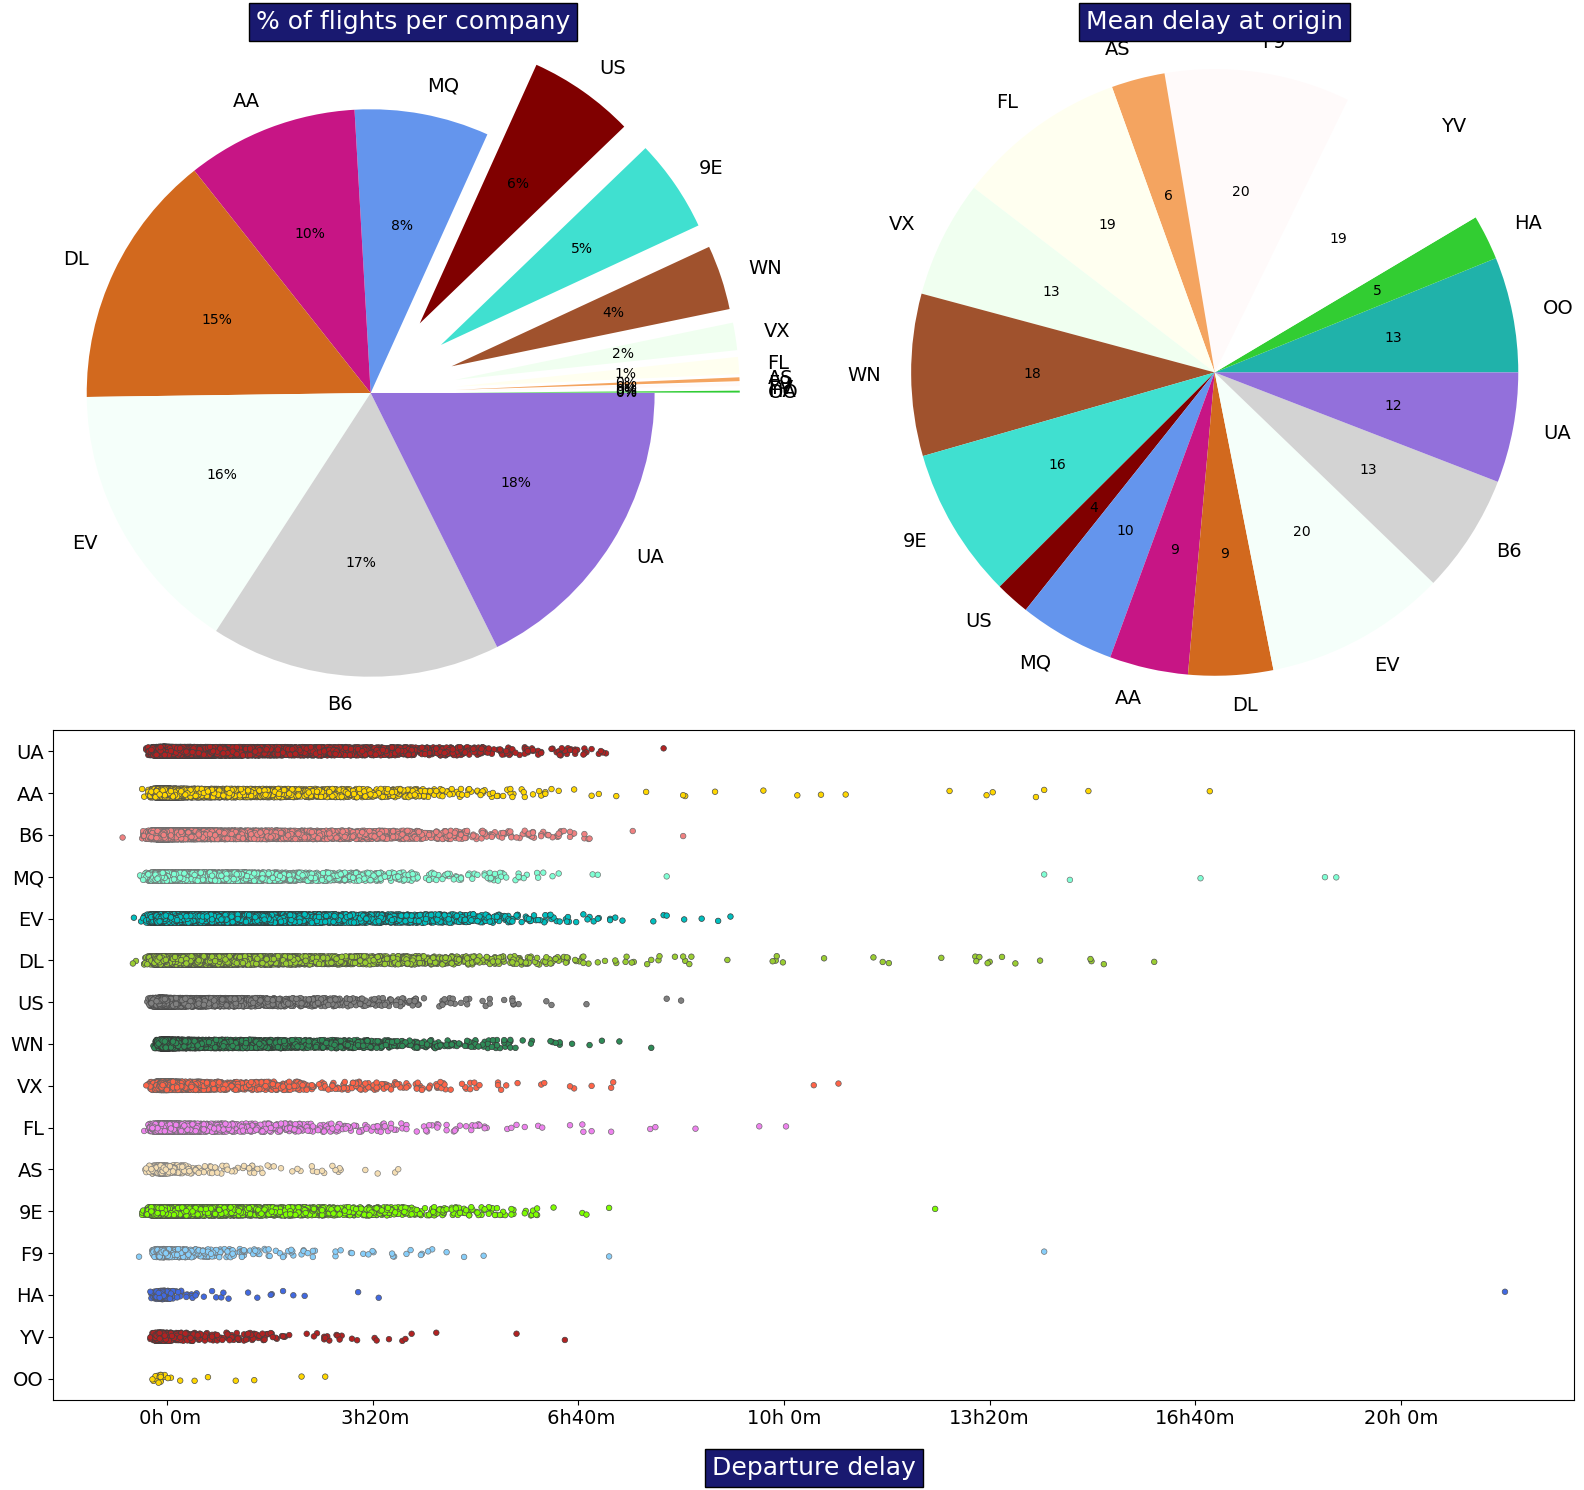

In [19]:
# plot delay information per carrier using pie charts:
plot_pie_delay_per_carrier_s(df)

#### Number of delayed flights per carrier

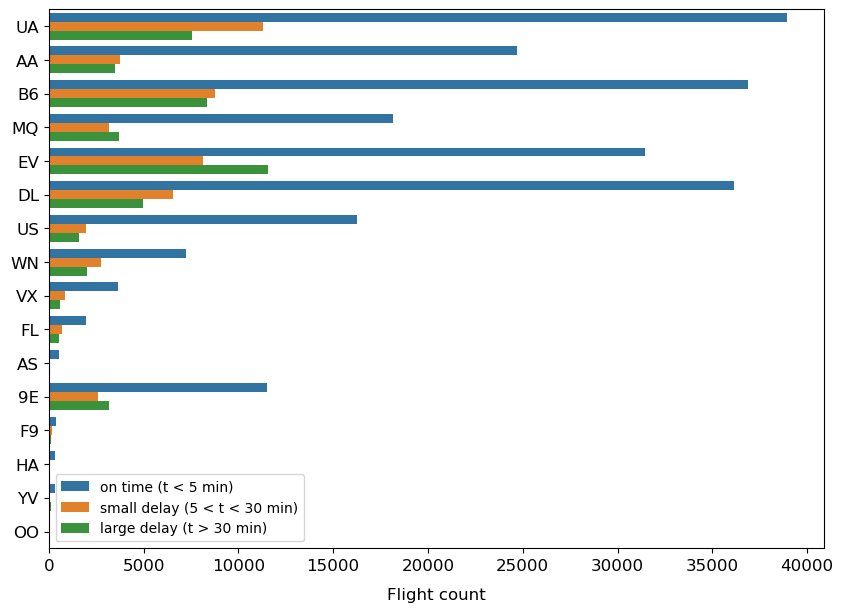

In [20]:
# Show per carrier the number of flights within delay classes: normal, small and large delay
plot_num_flight_grouped_delay(df)    

### Scatterplots on the relationship of departure delay with distance, air time and number of flights

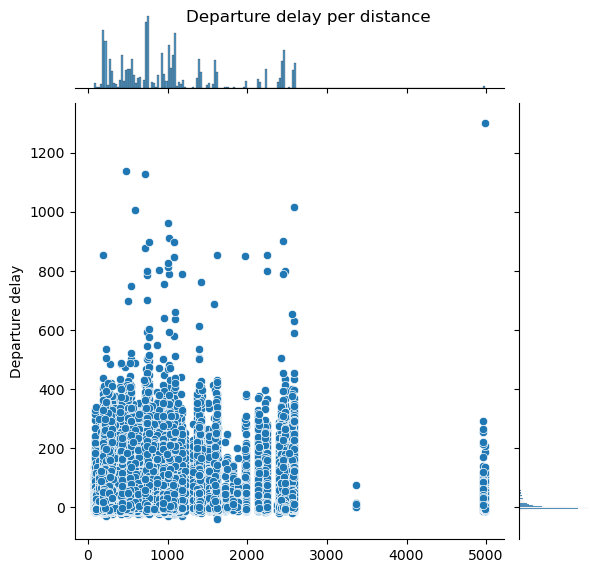

In [21]:
g= sns.jointplot(x='distance',y='dep_delay', data=df)
g.fig.suptitle("Departure delay per distance")
g.set_axis_labels(ylabel='Departure delay')

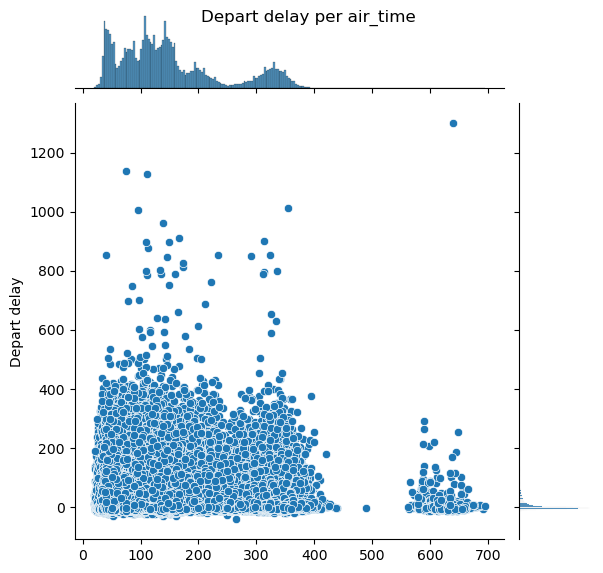

In [22]:
#df.plot.scatter(x='air_time',y='dep_delay',title= 'Depart delay per air_time', ylabel='Depart delay')
g= sns.jointplot(x='air_time',y='dep_delay', data=df)
g.fig.suptitle("Depart delay per air_time")
g.set_axis_labels(ylabel='Depart delay')

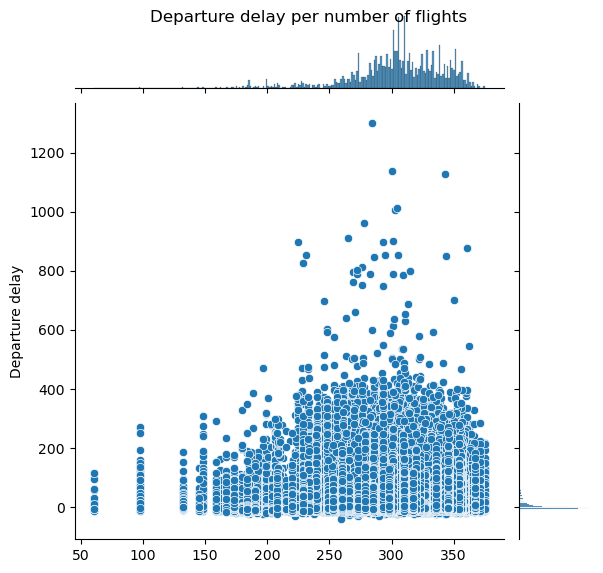

In [23]:
#df.plot.scatter(x='num_flights',y='dep_delay',title= 'Depart delay per number of flights', ylabel='Depart delay')
g= sns.jointplot(x='num_flights',y='dep_delay', data=df)
g.fig.suptitle("Departure delay per number of flights")
g.set_axis_labels(ylabel='Departure delay')

#### Delay per origin

<AxesSubplot:title={'center':'Delay per origin'}, xlabel='origin'>

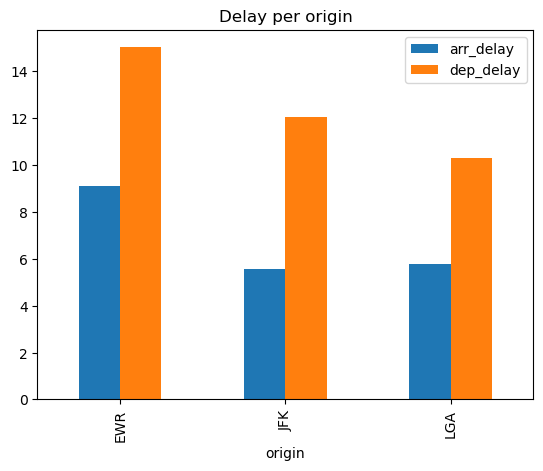

In [24]:
df[['origin','arr_delay', 'dep_delay']].groupby('origin').mean().plot(title= 'Delay per origin',kind='bar')

#### Delay per week day

<AxesSubplot:title={'center':'Delay per week day'}, xlabel='weekday'>

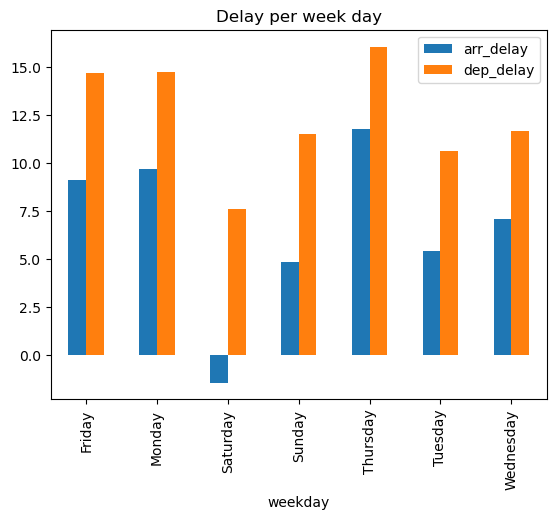

In [25]:
df[['weekday','arr_delay', 'dep_delay']].groupby('weekday').mean().plot(title= 'Delay per week day',kind='bar')

#### Distribution of the number of flights across weekdays 

Text(0.5, 1.0, 'Number of flights per week day')

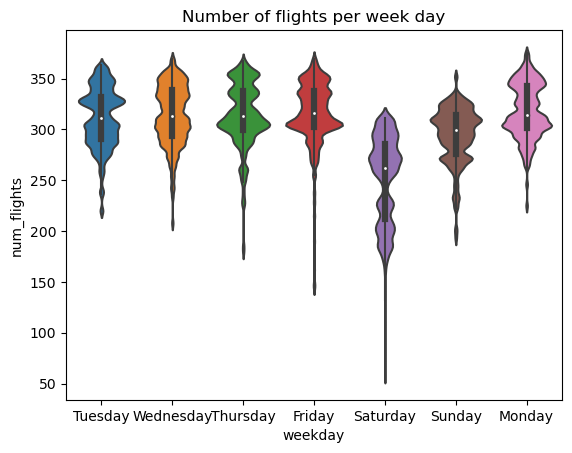

In [26]:
g = sns.violinplot(data=df, x="weekday", y="num_flights")
g.set_title("Number of flights per week day")

#### Number of flights throughout the year

<AxesSubplot:title={'center':'Number of flights per date'}, xlabel='date'>

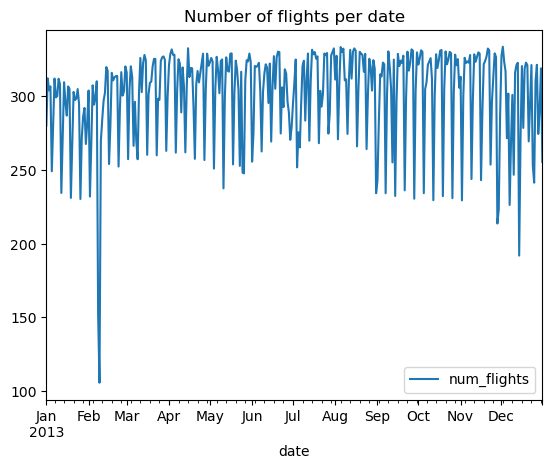

In [27]:
mean_dep_delay_per_date = df[['date','num_flights']].groupby(['date']).mean()
mean_dep_delay_per_date.plot(title= 'Number of flights per date')

#### Delay per month

<AxesSubplot:title={'center':'Delay per origin'}, xlabel='month'>

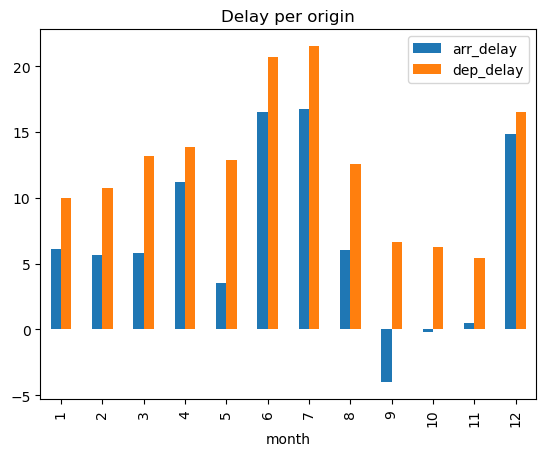

In [28]:
df[['month','arr_delay', 'dep_delay']].groupby('month').mean().plot(title= 'Delay per origin',kind='bar')

#### Delay per week

<AxesSubplot:title={'center':'Delay per week'}, xlabel='week_num'>

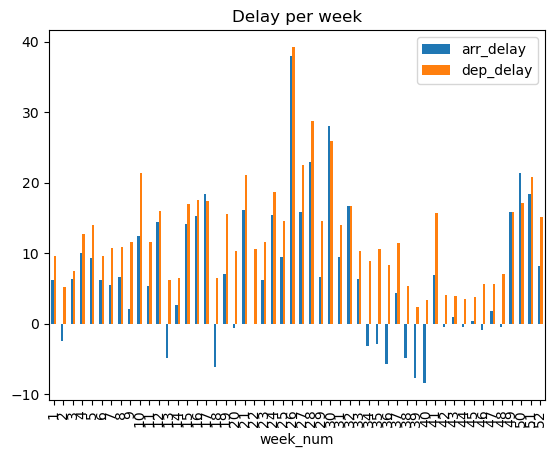

In [29]:
df[['week_num','arr_delay', 'dep_delay']].groupby('week_num').mean().plot(title= 'Delay per week',kind='bar')

#### Average departure delay throughout the year

<AxesSubplot:title={'center':'Delay per date'}, xlabel='date'>

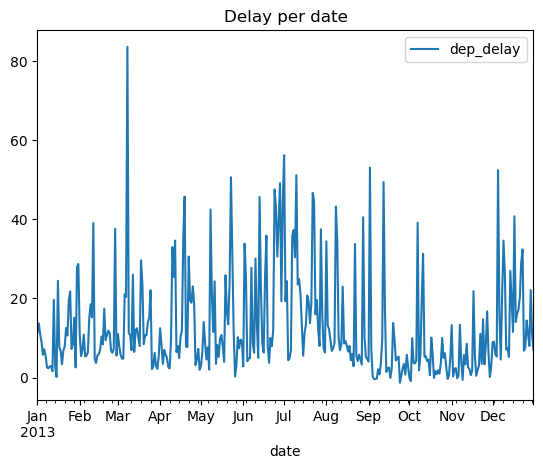

In [30]:
mean_dep_delay_per_date = df[['date','dep_delay']].groupby(['date']).mean()
mean_dep_delay_per_date.plot(title= 'Delay per date')

#### Boxplots of departure delay across months

Text(0, 0.5, 'Depature delay')

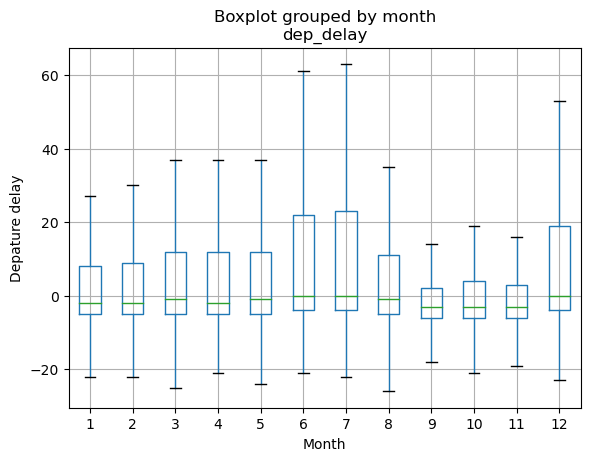

In [31]:
g = df[['dep_delay','month']].boxplot(by='month',showfliers=0)
g.set_xlabel('Month'); g.set_ylabel('Depature delay')

#### Autocorrelation of departure delays across origin airports

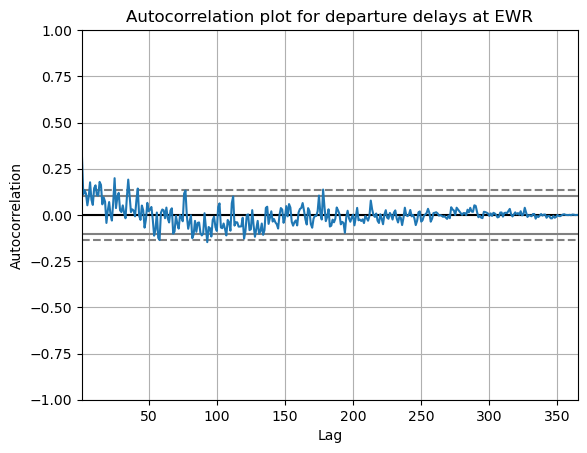

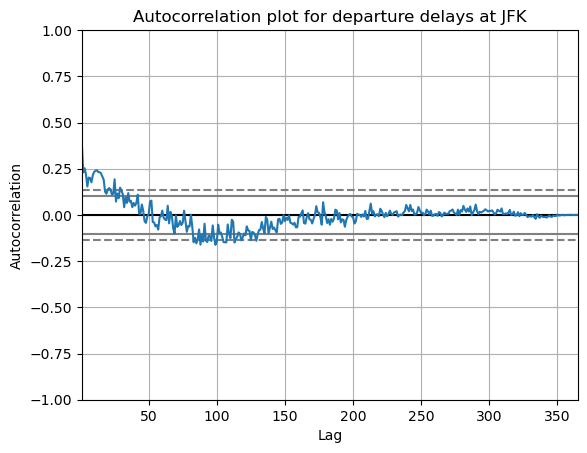

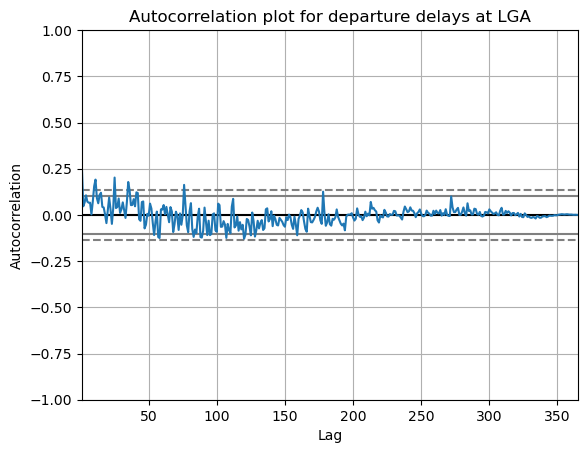

In [32]:
from pandas.plotting import autocorrelation_plot
mean_dep_delay_per_date = df[['origin','date','dep_delay']].groupby(['origin','date']).mean()
for i in np.unique(mean_dep_delay_per_date.index.get_level_values('origin')):
    autocorrelation_plot(mean_dep_delay_per_date[mean_dep_delay_per_date.index.get_level_values('origin')==i])
    plt.title('Autocorrelation plot for departure delays at '+i)
    plt.show()


### Test for correlations

In [33]:
from scipy.stats import  kendalltau, spearmanr, pearsonr
def correlation_tests(df, x1_name, x2_name, alpha = 0.05):
    x1 = df[x1_name]
    x2 = df[x2_name]
    print("----------------------------------------------------------------------------------")
    stat, p = spearmanr(x1,x2)
    print("Spearman      correlation of %s and %s: %.1f. The p-value is %.3f " % (x1_name, x2_name,stat, p)) 
    stat, p = pearsonr(x1,x2)
    print("Pearson       correlation of %s and %s: %.1f. The p-value is %.3f " % (x1_name, x2_name,stat, p))      
    stat, p = kendalltau(x1,x2)
    print("Kendall\'s tau correlation of %s and %s: %.1f. The p-value is %.3f " % (x1_name, x2_name,stat, p))
    print("----------------------------------------------------------------------------------") 
    
correlation_tests(df,'distance','arr_delay')  
correlation_tests(df,'num_flights','arr_delay')  

correlation_tests(df,'distance','dep_delay')  
correlation_tests(df,'num_flights','dep_delay')  

    
correlation_tests(df,'avg_dep_delay_last_1_day','dep_delay')  
correlation_tests(df,'avg_dep_delay_last_2_days','dep_delay')  

correlation_tests(df,'avg_dep_delay_last_1_day_at_carrier','dep_delay')  

----------------------------------------------------------------------------------
Spearman      correlation of distance and arr_delay: -0.1. The p-value is 0.000 
Pearson       correlation of distance and arr_delay: -0.1. The p-value is 0.000 
Kendall's tau correlation of distance and arr_delay: -0.0. The p-value is 0.000 
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Spearman      correlation of num_flights and arr_delay: 0.0. The p-value is 0.000 
Pearson       correlation of num_flights and arr_delay: 0.0. The p-value is 0.089 
Kendall's tau correlation of num_flights and arr_delay: 0.0. The p-value is 0.000 
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Spearman      correlation of distance and dep_delay: 0.1. The p-value is 0.000 
Pearson      

## Predictive analysis

### Determine which feature variables are considered

In [34]:
# describe the target variable:
df['depart_delay_is_large'].describe()

count    327346.000000
mean          0.146344
std           0.353451
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: depart_delay_is_large, dtype: float64

In [35]:
# define the initial list of feature variables:
x_vars = [ 'distance', 'num_flights',  'sched_dep_time',
          'avg_dep_delay_last_1_day','avg_dep_delay_last_2_days', 
          'avg_dep_delay_last_1_day_at_origin_carrier', 'avg_dep_delay_last_2_days_at_origin_carrier',
          'num_previous_delays',  
          'avg_previous_delays', 
         ]

### Show heatmap of correlations of target variable 'depart delay is larger than 30 mins' with feature variables

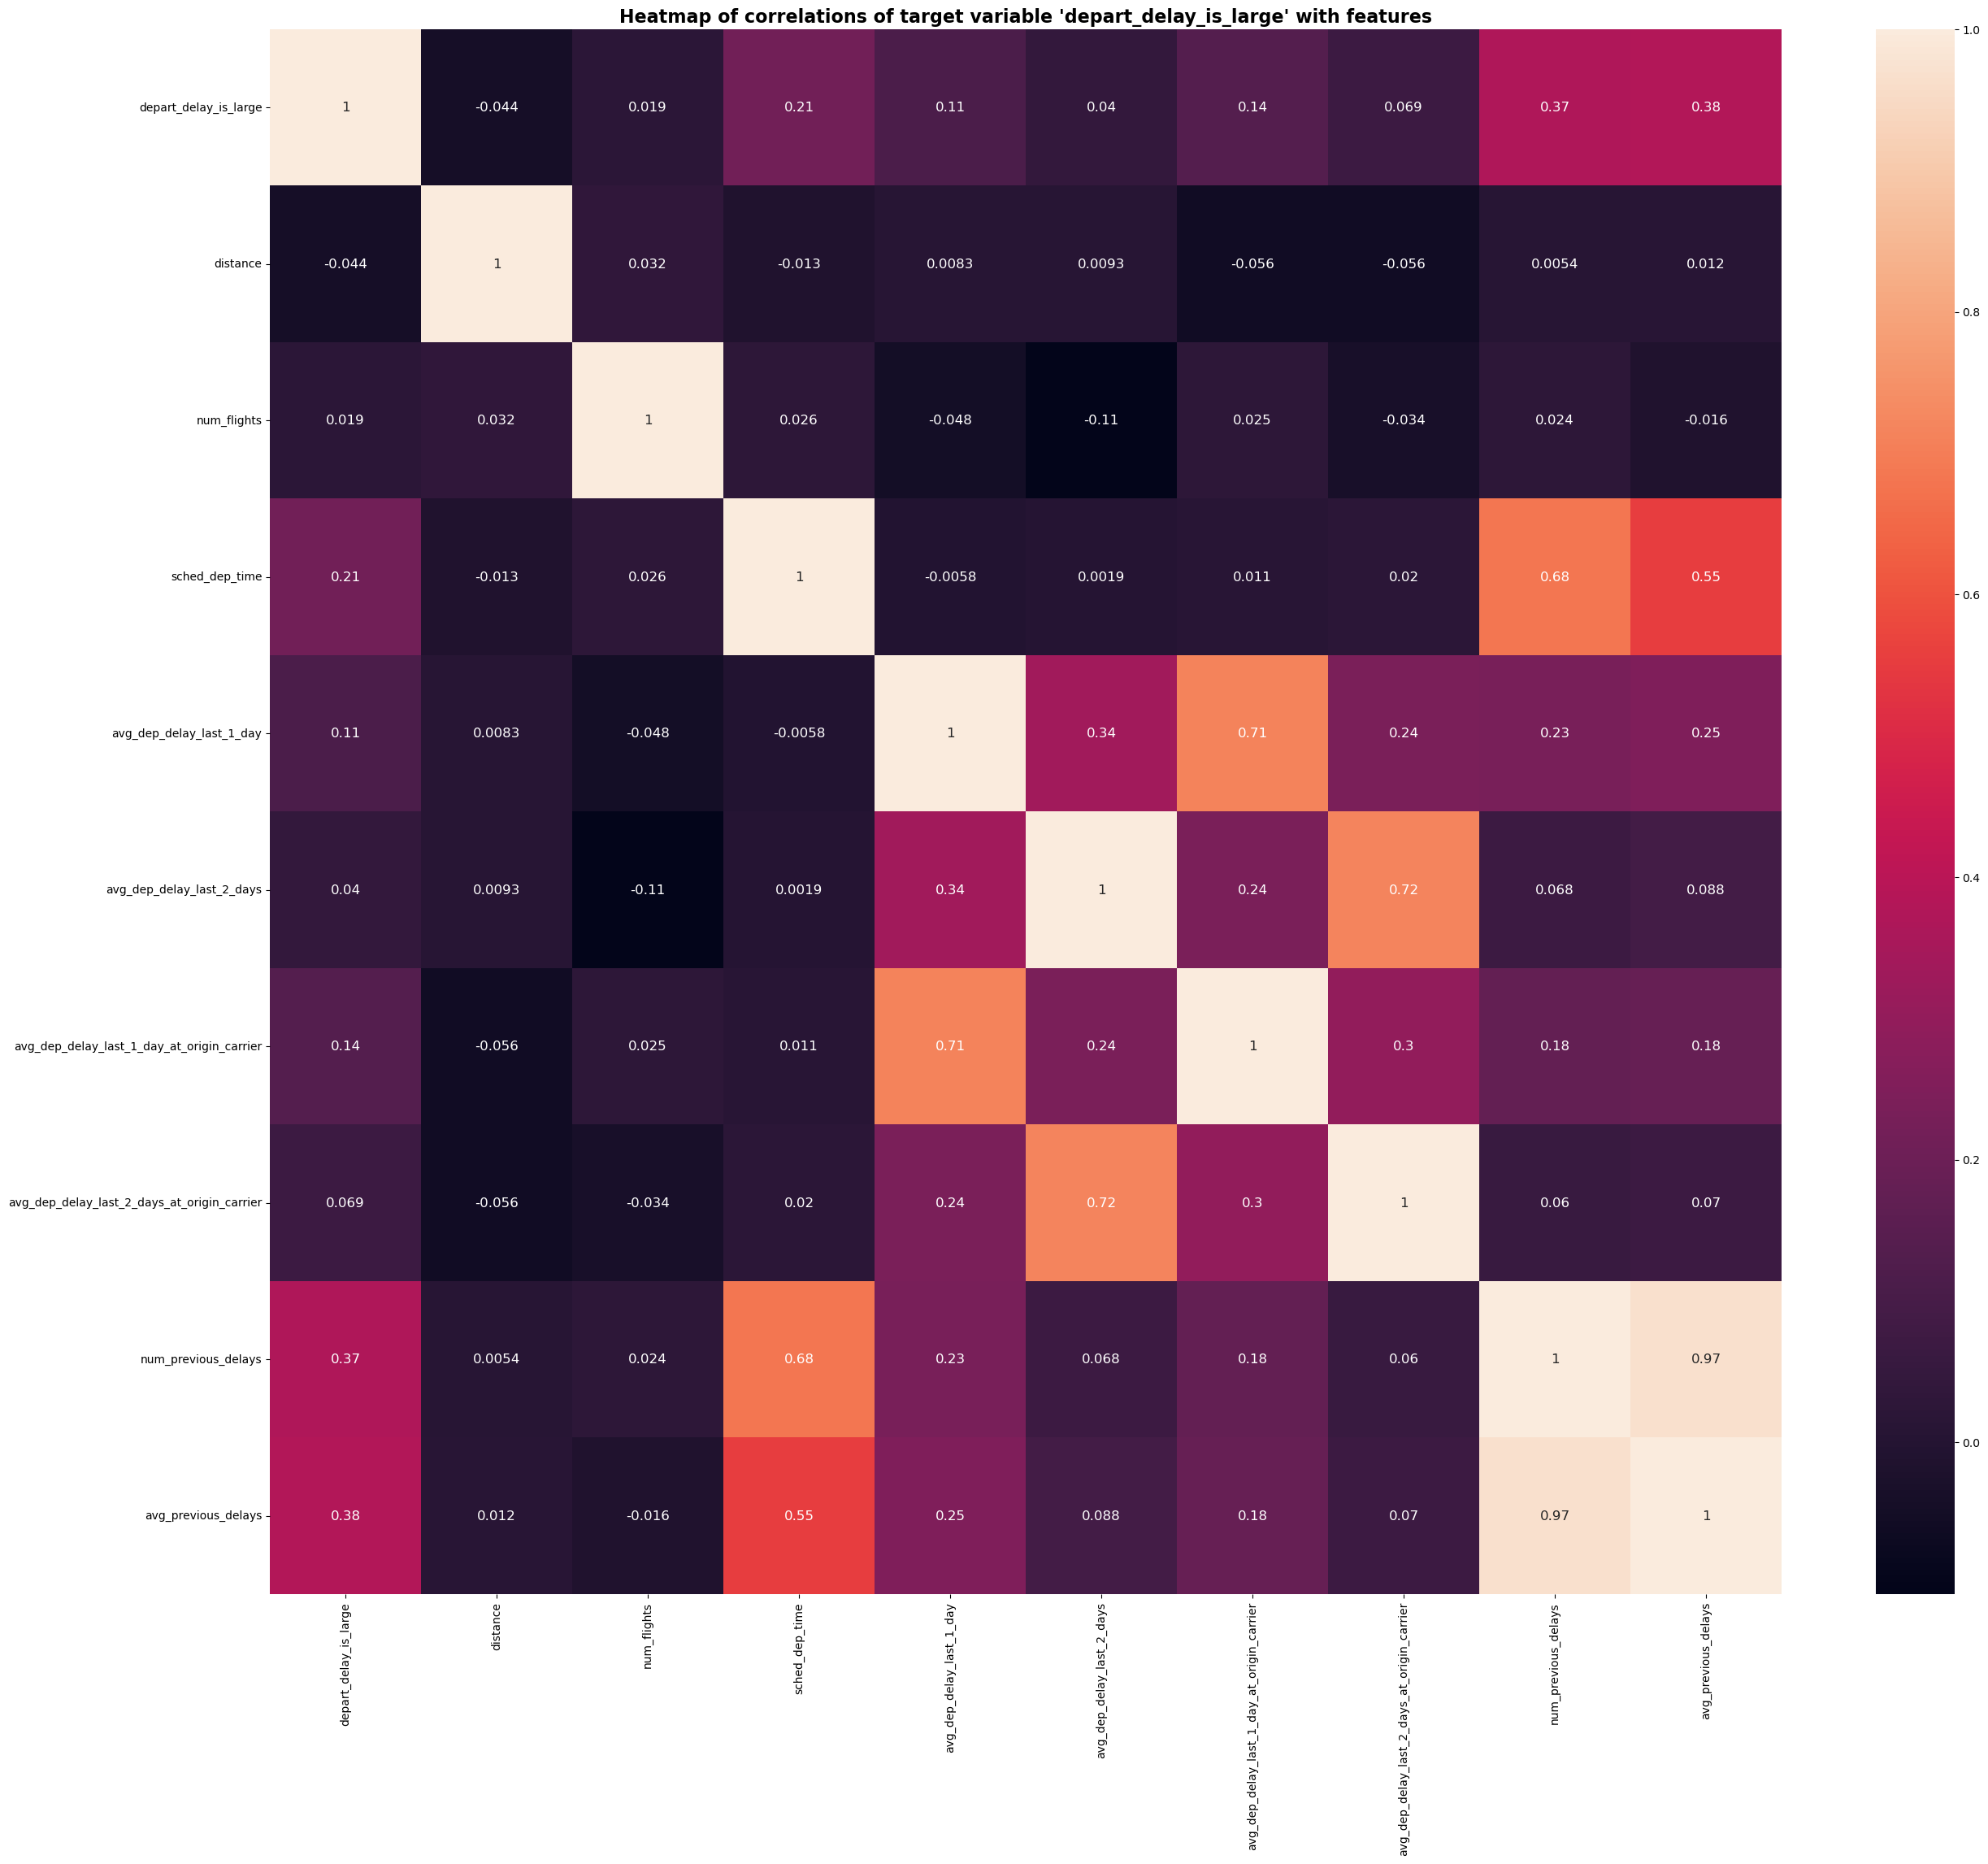

In [36]:
fig,ax = plt.subplots(nrows =1, ncols = 1, figsize = (30,25))
corr1 = df[['depart_delay_is_large']+ x_vars].corr()
sns.heatmap(corr1, annot = True, annot_kws={"fontsize":12})
plt.title('Heatmap of correlations of target variable \'depart_delay_is_large\' with features', fontsize=16, weight = 'bold')
plt.setp(ax.get_xticklabels(), fontsize=10, weight = 'normal');
plt.setp(ax.get_yticklabels(), fontsize=10, weight = 'normal');
plt.show()

In [37]:
# indicator to specify whether dummy variables should be used and manually computed.
# Otherwise non-numeric variables will be converted to the categorial pandas data type and certain ML classifier can interally automatically account for them with dummy variables.
USE_DUMMIES = 0

In [38]:
# If wanted, manually compute dummy variables for considered non-numeric features.

def convert_to_dummies(df1, var_name, x_vars=[], prefix=None, drop_first=True, drop_var_name= False):
        """Convert a given column of data frame to dummy variables where the first option is dropped.""" 
        dummies = pd.get_dummies(df1[var_name], prefix=prefix, drop_first=drop_first) 
        dummies = dummies.fillna(0)
        dummy_var_names = dummies.columns.tolist()
        if all([i not in df1.columns  for i in dummy_var_names ]):
            if drop_var_name:
                df1    = df1.drop(var_name, axis=1)
            x_vars = [i for i in x_vars if i != var_name]
            df1 = pd.concat([df1, dummies], axis=1)
        if all([i not in x_vars  for i in dummy_var_names ]):    
            x_vars1 = x_vars + dummy_var_names
        else:
            x_vars1 = x_vars
        return (df1, x_vars1)       

# Add the carrier specific constants:
if 1 and USE_DUMMIES:
    df, x_vars = convert_to_dummies(df, 'carrier', x_vars, prefix= 'carrier', drop_first=False)
else:
    x_vars += ['carrier']
    
# Add the origin specific constants:
if 1 and USE_DUMMIES:
    df, x_vars = convert_to_dummies(df, 'origin', x_vars, prefix= 'origin')
else:
    x_vars += ['origin']
    
# Add the destination specific constants:
if 0 and USE_DUMMIES:
    df, x_vars = convert_to_dummies(df, 'dest', x_vars, prefix= 'dest')
elif 0:
    x_vars += ['dest']    
    
# Add the hour specific constants:
if 1 and USE_DUMMIES:
    df, x_vars = convert_to_dummies(df, 'hour', x_vars, prefix= 'hour')
elif 0:
    x_vars += ['hour']   
    
# Add the month specific constants:
if 1 and USE_DUMMIES:
    df, x_vars = convert_to_dummies(df, 'month_name', x_vars)
else:
    x_vars += ['month_name']    
    
# Add the week_day specific constants:
if 1 and USE_DUMMIES:
    df, x_vars = convert_to_dummies(df, 'weekday', x_vars)
else:
    x_vars += ['weekday']   
    
# Add the week specific constants:
if 0 and USE_DUMMIES:
    df, x_vars = convert_to_dummies(df, 'week_num', x_vars, prefix= 'week')
elif 0:
    x_vars += ['week_num']      

print('List of applied feature variables:\n')
print(x_vars)

List of applied feature variables:

['distance', 'num_flights', 'sched_dep_time', 'avg_dep_delay_last_1_day', 'avg_dep_delay_last_2_days', 'avg_dep_delay_last_1_day_at_origin_carrier', 'avg_dep_delay_last_2_days_at_origin_carrier', 'num_previous_delays', 'avg_previous_delays', 'carrier', 'origin', 'month_name', 'weekday']



Out-of-sample prediction performance:

                                    Prediction Performance
AUC_ROC                                               0.79
Accuracy  [=(tp+tn)/(tp+tn+fp+fn)]                    0.87
Precision [=tp/(tp+fp)]                               0.22
Recall    [=tp/(tp+fn)]                               0.67
f1 score  [=(2*tp)/(2*tp+fp+fn)]                      0.33
True Positive  (tp)                                3188.00
True Negative  (tn)                               81332.00
False Positive (fp)                               11369.00
False Negative (fn)                                1581.00


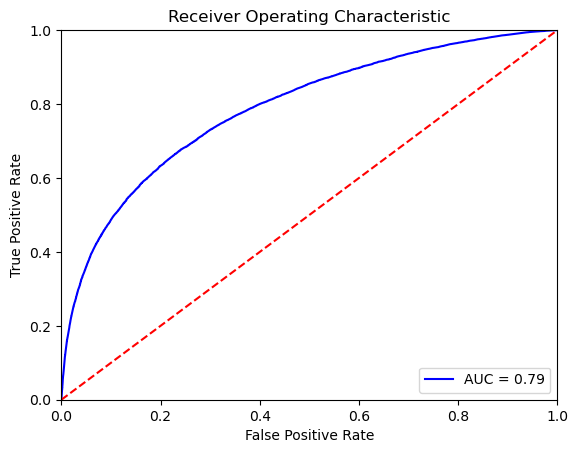

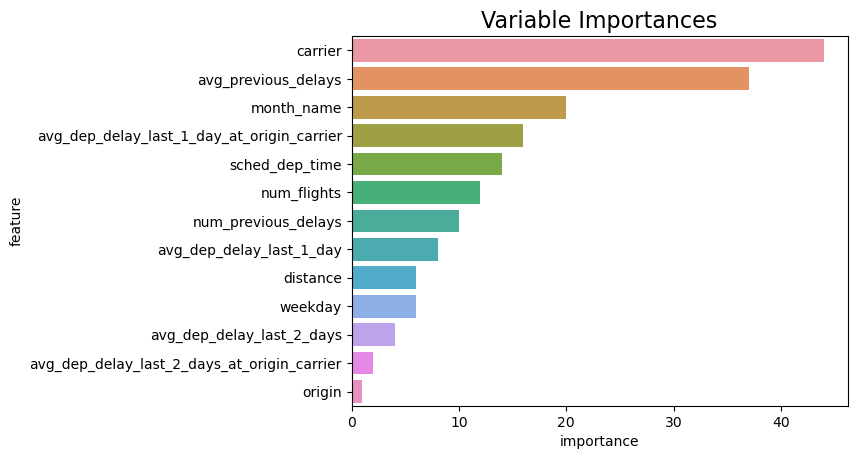

In [39]:
# tune, train, predict and plot model results
# to do so call the tunning, training, predicting and ploting function.
# Using a gradient boosting classifier with 70% of the data for training and 30% as holdout sample. 
# The training and test data is randomly chosen based on the random assignement of days of observation to either the training or test set.
# For the hyperparmeter tuning, we use a five-fold crossvalidation on the traing data set with 10 parameter settings sampled from random search. 
# Random search can cover a larger area of the paramter space with the same number of consider setting compared to e.g. grid search.

trained_model = train_pred_model(df, x_vars = x_vars, horizon = 0.3, model_type = 'lgbm', output_folder_plots = output_folder_plots, TUNE = 0, SAVE_OUTPUT = 1)

In [40]:
# save or load the trained model 
import pickle
if 1:
    pickle.dump(trained_model, open(output_folder_model+'trained_model.pkl', "wb"))

In [41]:
# load the trained model:
if 0:
    trained_model = pickle.load(open(output_folder_model+'trained_model.pkl', "rb"))